In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

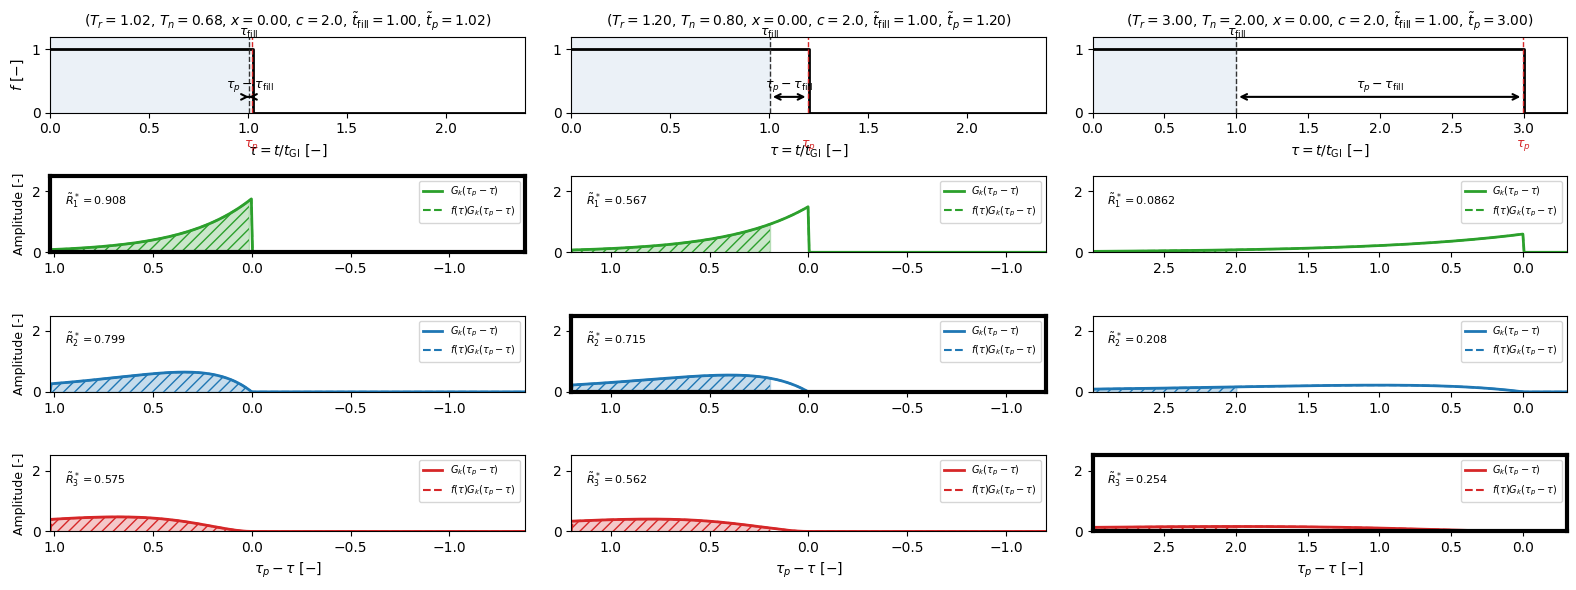

In [2]:
xlsx_name="Rainfall Results(Uniform)"

def load_case(xlsx_path, case_id):
    meta = pd.read_excel(xlsx_path, sheet_name="meta")
    row = meta.loc[meta["case_id"] == case_id].iloc[0].to_dict()

    rain = pd.read_excel(xlsx_path, sheet_name=f"case{case_id}_rain")
    b1 = pd.read_excel(xlsx_path, sheet_name=f"case{case_id}_b1")
    b2 = pd.read_excel(xlsx_path, sheet_name=f"case{case_id}_b2")
    b3 = pd.read_excel(xlsx_path, sheet_name=f"case{case_id}_b3")

    return row, rain, [b1, b2, b3]

def plot_figure_from_excel(xlsx_path, pdf_out="figure 4.pdf"):
    meta = pd.read_excel(xlsx_path, sheet_name="meta")
    n_cases = int(meta["case_id"].max())

    fig, axes = plt.subplots(4, n_cases, figsize=(16, 6), sharex=False, sharey=False)

    branch_colors = ["tab:green", "tab:blue", "tab:red"]
    branch_names = ["Lower", "Middle", "Upper"]
    branch_ms = [1, 2, 3]

    for j in range(1, n_cases + 1):
        row, rain, branches = load_case(xlsx_path, j)

        ax0 = axes[0, j-1]
        ax1 = axes[1, j-1]
        ax2 = axes[2, j-1]
        ax3 = axes[3, j-1]
        bax = [ax1, ax2, ax3]

        t_tilde = rain["t_tilde"].to_numpy(float)
        r_step = rain["r_step"].to_numpy(float)
        r_plot = rain["r_plot"].to_numpy(float)

        t_fill_tilde = float(row["t_fill_tilde"])
        t_p_tilde = float(row["t_p_tilde"])
        t_plot_max = float(row["t_plot_max"])
        t_GI = float(row["t_GI"])
        Tr_ref = float(row["Tr_ref"])
        Tn_ref = float(row["Tn_ref"])
        x_mode = float(row["x_mode"])
        c_conc = float(row["c_conc"])

        ax0.step(t_tilde, r_step, where="post", color="k", lw=2)
        ax0.axvspan(0, t_fill_tilde, color="#dce6f2", alpha=0.55)
        ax0.axvline(t_fill_tilde, color="0.2", lw=1, ls="dashed")
        ax0.axvline(t_p_tilde, color="C3", lw=1, ls="dashed")

        mid_tilde = 0.5 * (t_fill_tilde + t_p_tilde)
        y_arrow = float(np.nanmax(r_plot)) * 0.25
        ax0.annotate("", xy=(t_fill_tilde, y_arrow), xytext=(t_p_tilde, y_arrow),
                     arrowprops=dict(arrowstyle="<->", lw=1.5))
        ax0.text(mid_tilde, y_arrow + 0.05, r"$\tau_p - \tau_{\mathrm{fill}}$",
                 ha="center", va="bottom", fontsize=9)

        ax0.text(t_fill_tilde, float(np.nanmax(r_plot)) * 1.15, r"$\tau_{\mathrm{fill}}$",
                 ha="center", va="bottom", fontsize=9)
        ax0.text(t_p_tilde, -0.40, r"$\tau_p$", ha="center", va="top", fontsize=9, color="C3")

        ax0.set_xlim(0, t_plot_max / t_GI)
        ax0.set_ylim(0.0, 1.2)
        ax0.set_ylabel(r"$f~[-]$", fontsize=10)
        ax0.set_xlabel(r"$\tau = t/t_{\mathrm{GI}}~[-]$", fontsize=10)

        title_param = (f"($T_r={Tr_ref:.2f}$, $T_n={Tn_ref:.2f}$, "
                       f"$x={x_mode:.2f}$, $c={c_conc:.1f}$, "
                       f"$\\tilde t_{{\\rm fill}}={t_fill_tilde:.2f}$, "
                       f"$\\tilde t_p={t_p_tilde:.2f}$)")
        ax0.set_title(title_param, fontsize=10, pad=8)

        for ax, bdf, col, name, m in zip(bax, branches, branch_colors, branch_names, branch_ms):
            tau_tilde = bdf["tau_tilde"].to_numpy(float)
            g = bdf["g"].to_numpy(float)
            rg = bdf["rg"].to_numpy(float)
            mask_fill = bdf["mask_fill_range"].to_numpy(int).astype(bool)

            ax.plot(tau_tilde, g, color=col, lw=2, label=r"$G_k(\tau_p-\tau)$")
            ax.plot(tau_tilde, rg, color=col, lw=1.5, ls="--", label=r"$f(\tau)G_k(\tau_p-\tau)$")

            ax.fill_between(tau_tilde, 0, g, where=mask_fill, color=col, alpha=0.25)
            ax.fill_between(tau_tilde, 0, rg, where=mask_fill,
                            facecolor="none", edgecolor=col, hatch="///", linewidth=0)

            if m == 3:
                ax.set_xlabel(r"$\tau_p - \tau~[-]$", fontsize=10)
            ax.set_ylabel("Amplitude [-]", fontsize=9)

            ax.set_xlim(t_p_tilde, (t_p_tilde - (t_plot_max / t_GI)))
            ax.set_ylim(0, 2.5)
            ax.legend(loc="upper right", fontsize=7)

            rk = float(row[f"Rtilde_{name[0]}"]) if f"Rtilde_{name[0]}" in row else np.nan
            ax.text(0.03, 0.80, fr"$\tilde R_{{{m}}}^*={rk:.3g}$",
                    transform=ax.transAxes, ha="left", va="top", fontsize=8,
                    bbox=dict(facecolor="white", alpha=0.75, edgecolor="none"))

        idx_best = int(row["idx_best"])
        if idx_best in (0, 1, 2):
            best_ax = bax[idx_best]
            for spine in best_ax.spines.values():
                spine.set_linewidth(3.0)
                spine.set_edgecolor("k")

        if j > 1:
            for i in range(4):
                axes[i, j-1].set_ylabel("")

    plt.tight_layout()
    plt.savefig(pdf_out, dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    xlsx_path = f"{xlsx_name}.xlsx"
    plot_figure_from_excel(xlsx_path=xlsx_path, pdf_out=f"{xlsx_name}.pdf")

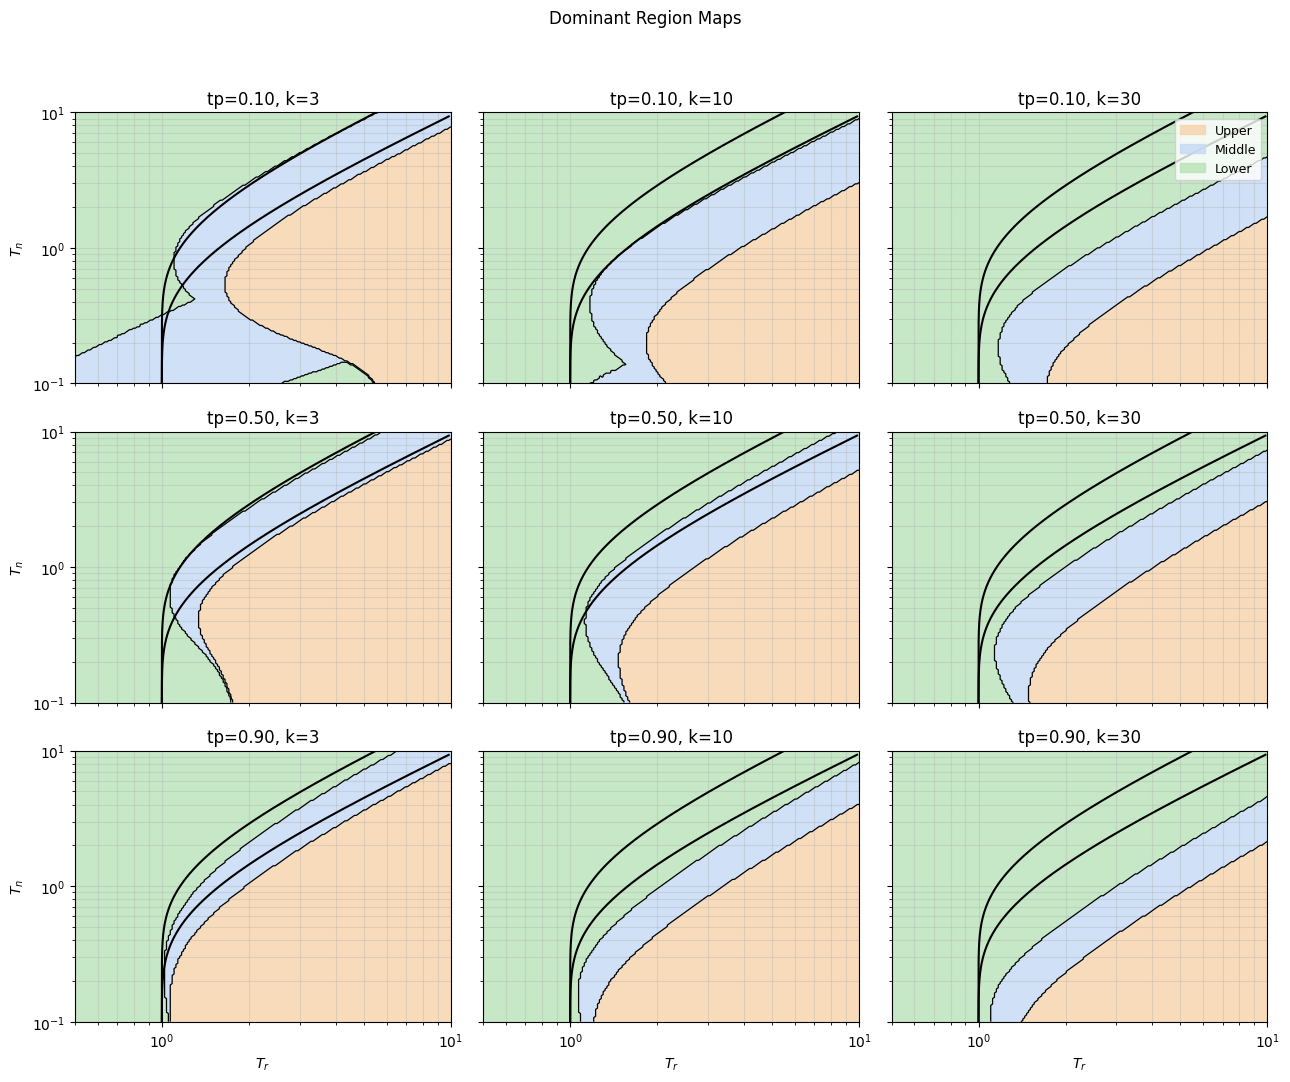

In [9]:
OUTPUT_BASENAME = "dominant_region_maps"
PNG_DPI         = 450

def load_inputs(xlsx_path):
    Tr_vals = pd.read_excel(xlsx_path, sheet_name="grid_Tr")["Tr_vals"].to_numpy(float)
    Tn_vals = pd.read_excel(xlsx_path, sheet_name="grid_Tn")["Tn_vals"].to_numpy(float)
    cfg = pd.read_excel(xlsx_path, sheet_name="config").iloc[0].to_dict()
    cases = pd.read_excel(xlsx_path, sheet_name="cases")
    return Tr_vals, Tn_vals, cfg, cases

def load_map(xlsx_path, case_id):
    Wmap = pd.read_excel(xlsx_path, sheet_name=f"case{case_id}_Wmap", header=None).to_numpy()
    TImap = pd.read_excel(xlsx_path, sheet_name=f"case{case_id}_TImap", header=None).to_numpy()
    Rmap = pd.read_excel(xlsx_path, sheet_name=f"case{case_id}_Rmap", header=None).to_numpy()
    return Wmap.astype(int), TImap.astype(int), Rmap.astype(float)

def plot_board(xlsx_path, pdf_out, png_out):
    Tr_vals, Tn_vals, cfg, cases = load_inputs(xlsx_path)

    n_cases = len(cases)
    nrows, ncols = 3, 3

    colors = ["#f7d3aa", "#c4d9f5", "#b8e3b8"]
    labels = ["Upper", "Middle", "Lower"]

    fig, axes = plt.subplots(nrows, ncols, figsize=(13, 11), sharex=True, sharey=True)

    for idx in range(n_cases):
        r = idx // ncols
        c = idx % ncols
        ax = axes[r, c]

        case_id = int(cases.loc[idx, "case_id"])
        title = str(cases.loc[idx, "label"])

        Wmap, TImap, _ = load_map(xlsx_path, case_id)

        ax.contourf(Tr_vals, Tn_vals, Wmap,
                    levels=[-0.5, 0.5, 1.5, 2.5],
                    colors=colors, alpha=0.8)
        ax.contour(Tr_vals, Tn_vals, Wmap,
                   levels=[0.5, 1.5],
                   colors="k", linewidths=0.9)

        Delta = 2.0 / Tn_vals
        Tr_H12 = 1.0 + 1.0/(np.exp(Delta) - 1.0)
        Tr_H23 = 1.0 + 1.0/(np.exp(0.5*Delta) - 1.0)

        Tr_min, Tr_max = float(cfg["Tr_min"]), float(cfg["Tr_max"])
        Tn_min, Tn_max = float(cfg["Tn_min"]), float(cfg["Tn_max"])

        Tr_H12_plot = np.where((Tr_H12 >= Tr_min) & (Tr_H12 <= Tr_max), Tr_H12, np.nan)
        Tr_H23_plot = np.where((Tr_H23 >= Tr_min) & (Tr_H23 <= Tr_max), Tr_H23, np.nan)

        ax.plot(Tr_H12_plot, Tn_vals, color="k", lw=1.5)
        ax.plot(Tr_H23_plot, Tn_vals, color="k", lw=1.5)

        ax.set_title(title)

        if bool(cfg["PLOT_LOGLOG"]):
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.grid(which="both", alpha=0.35)
        else:
            ax.grid(alpha=0.3)

    for c in range(ncols):
        axes[-1, c].set_xlabel(r"$T_r$")
    for r in range(nrows):
        axes[r, 0].set_ylabel(r"$T_n$")

    patches = [mpatches.Patch(color=colors[k], alpha=0.8, label=labels[k]) for k in range(3)]
    axes[0, -1].legend(handles=patches, loc="upper right", fontsize=9)

    mode_txt = "loglog" if bool(cfg["PLOT_LOGLOG"]) else "linear"
    fig.suptitle(f"Dominant Region Maps")

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    fig.savefig(png_out, dpi=PNG_DPI, bbox_inches="tight")
    fig.savefig(pdf_out, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    xlsx_path = "dominant_region_maps.xlsx"

    base_dir = os.path.dirname(os.path.abspath(xlsx_path))
    base_name = os.path.splitext(os.path.basename(xlsx_path))[0]

    pdf_path = os.path.join(base_dir, f"{base_name}.pdf")
    png_path = os.path.join(base_dir, f"{base_name}.png")

    plot_board(xlsx_path, pdf_out=pdf_path, png_out=png_path)


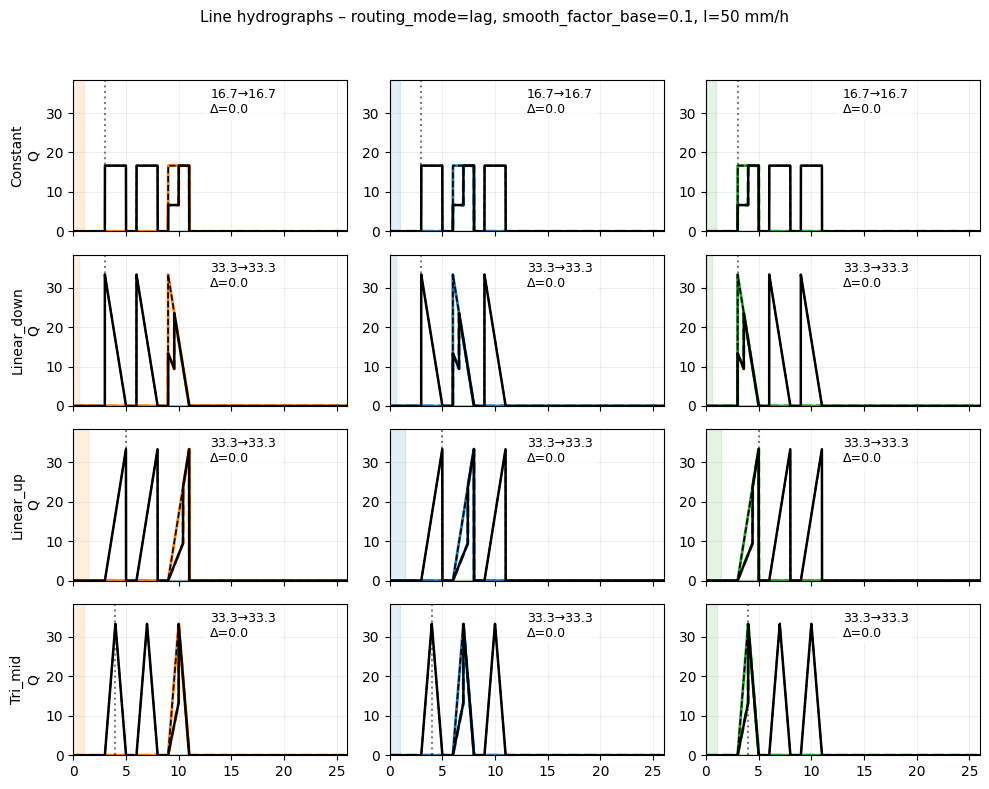

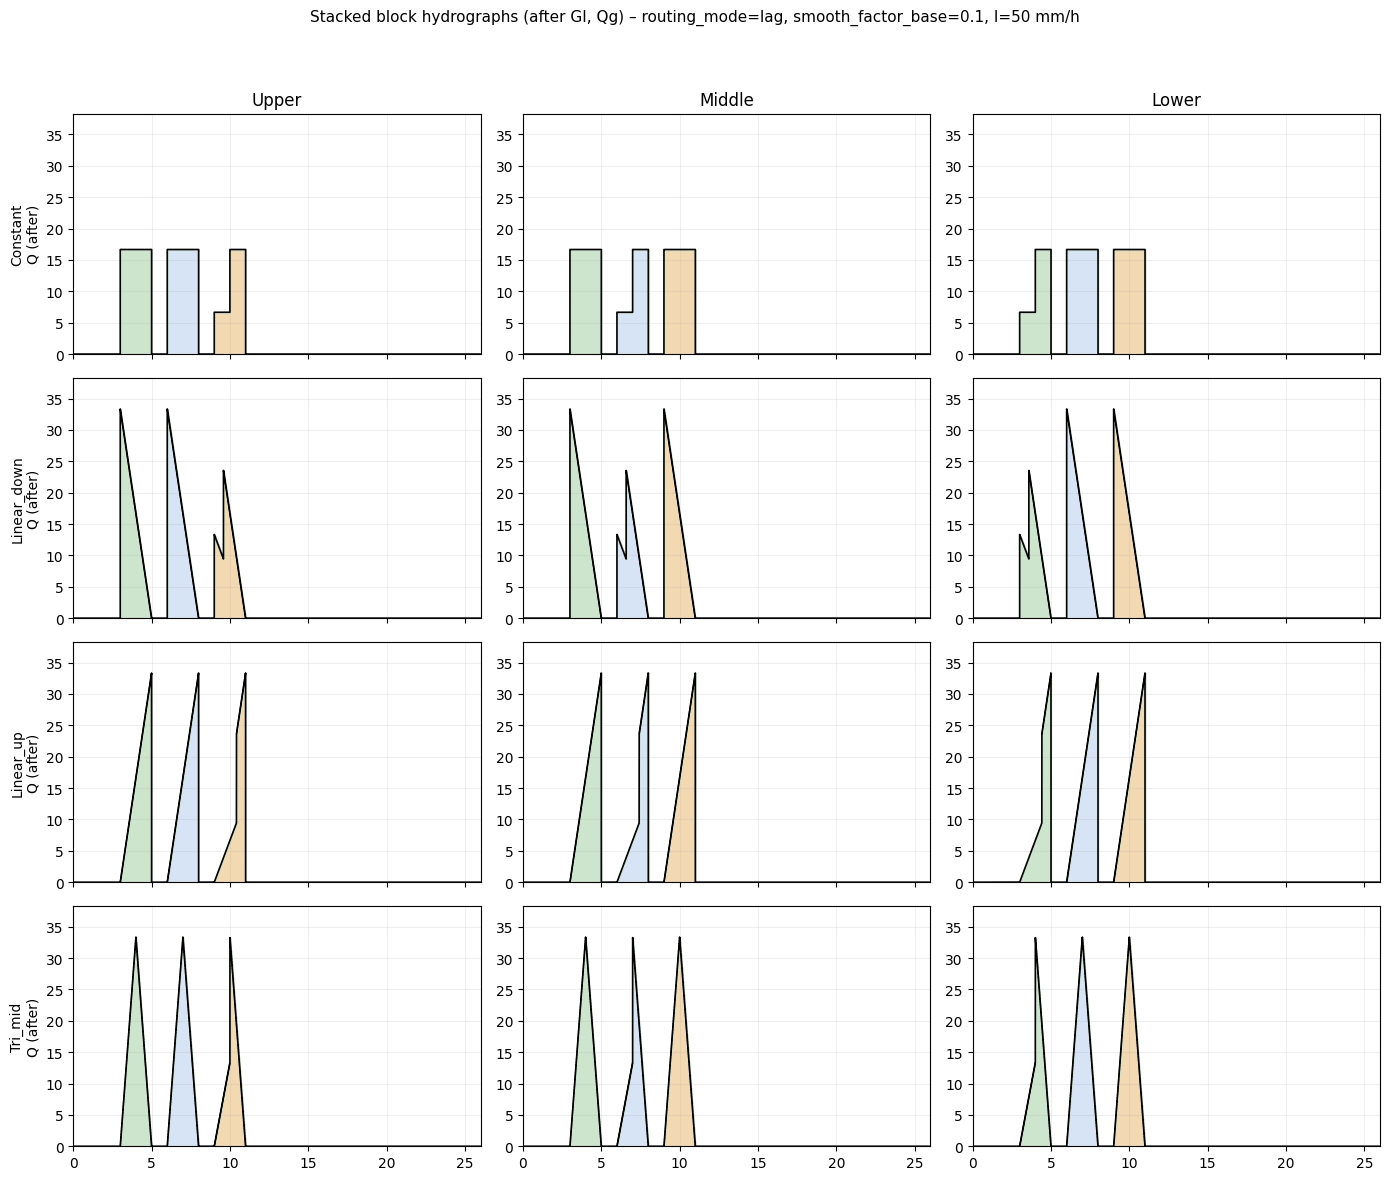

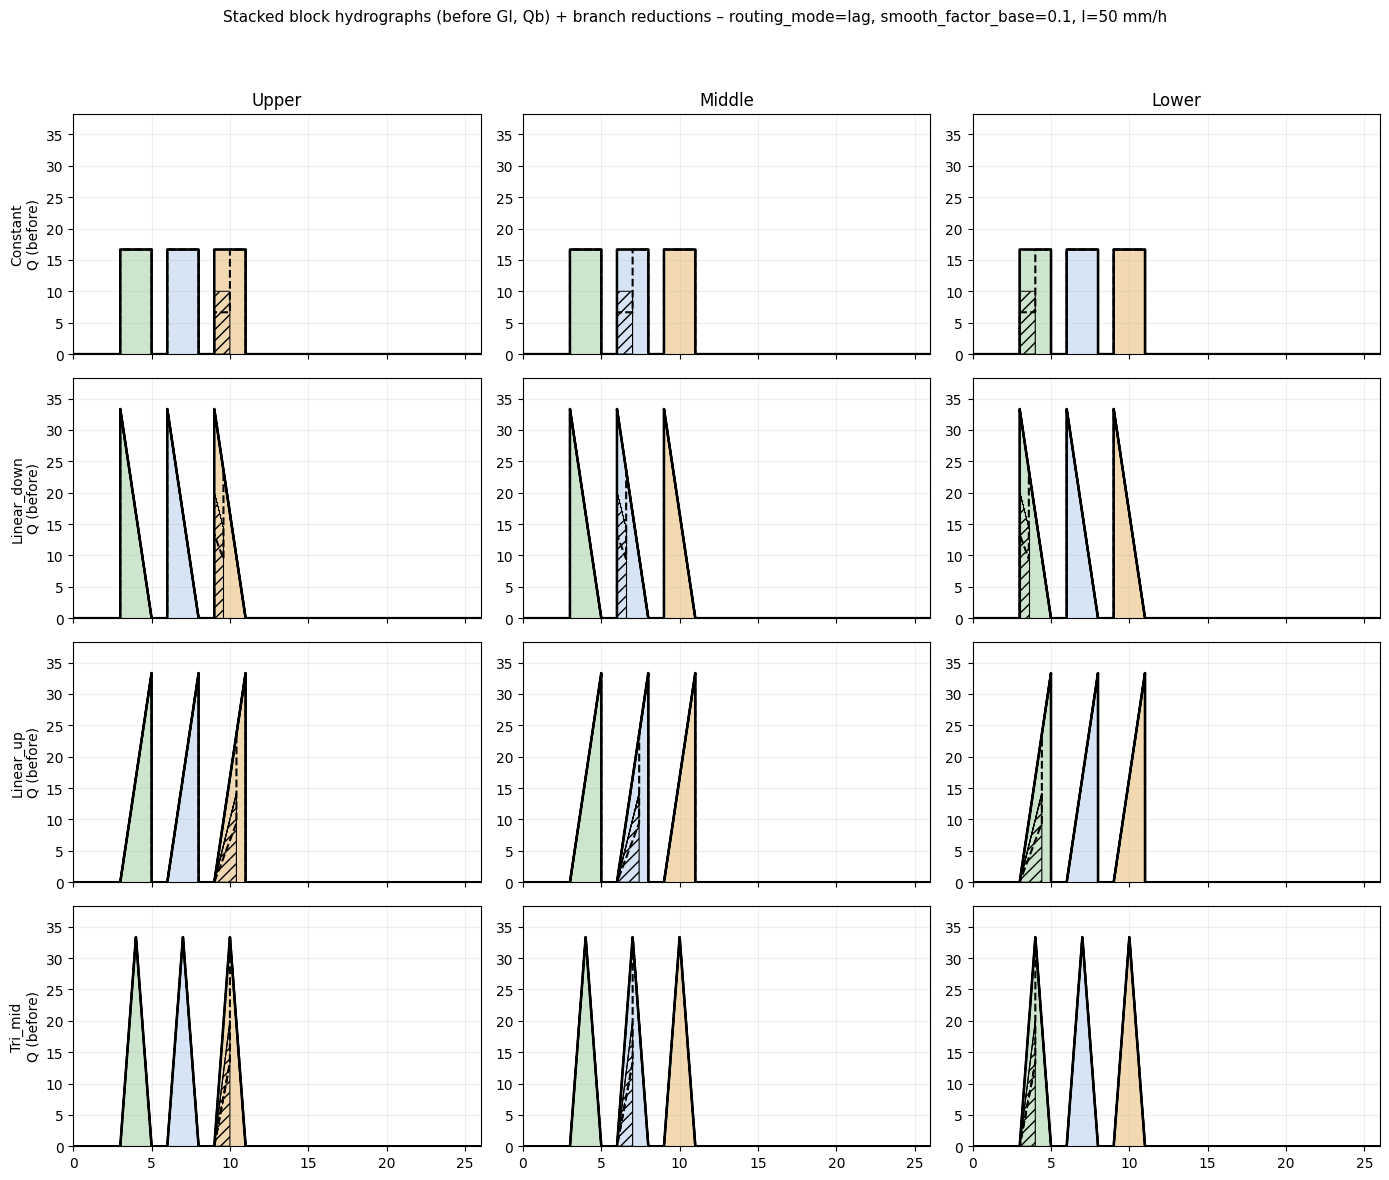

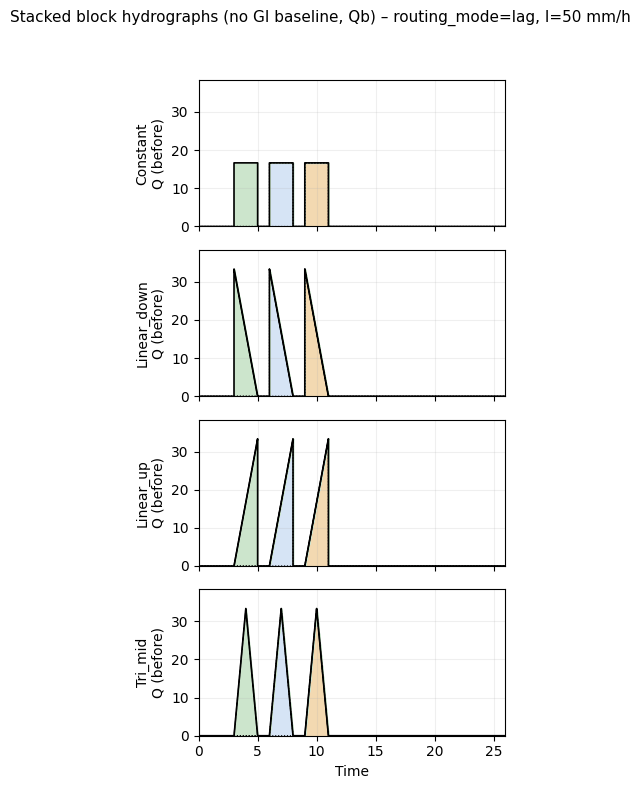

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def stack_cums(Q_upper, Q_middle, Q_lower):
    cumU = Q_upper
    cumUM = Q_upper + Q_middle
    cumUML = Q_upper + Q_middle + Q_lower
    return cumU, cumUM, cumUML

def plot_stacked(ax, t, Q_upper, Q_middle, Q_lower, x_end, ylim_val, fill_colors):
    cumU, cumUM, cumUML = stack_cums(Q_upper, Q_middle, Q_lower)
    ax.step(t, cumUML, where="post", color="k", lw=1.2)
    ax.fill_between(t, 0, cumU, step="post", color=fill_colors["Upper"], alpha=1.0)
    ax.fill_between(t, cumU, cumUM, step="post", color=fill_colors["Middle"], alpha=1.0)
    ax.fill_between(t, cumUM, cumUML, step="post", color=fill_colors["Lower"], alpha=1.0)
    ax.set_xlim(0, x_end)
    ax.set_ylim(0, ylim_val)
    ax.grid(alpha=0.2)

def read_cfg(xlsx_path):
    cfg = pd.read_excel(xlsx_path, sheet_name="config").iloc[0].to_dict()
    return cfg

def read_rows(xlsx_path):
    rows = pd.read_excel(xlsx_path, sheet_name="rows")
    return rows

def load_sheet(xlsx_path, sheet_name):
    return pd.read_excel(xlsx_path, sheet_name=sheet_name)

def plot_all_from_excel(xlsx_path):
    cfg = read_cfg(xlsx_path)
    rows = read_rows(xlsx_path)

    labels = ["Upper", "Middle", "Lower"]
    line_colors = ["tab:orange", "tab:blue", "tab:green"]

    fill_colors = {
        "Upper":  "#f3d9b1",
        "Middle": "#d6e4f5",
        "Lower":  "#cce5cc",
    }

    xlim_global = float(cfg["xlim_global"])
    ylim_val = float(cfg["ylim_val"])
    ylim_val4 = float(cfg["ylim_val4"])

    fig1, axes1 = plt.subplots(4, 3, figsize=(10, 8), sharex=True, sharey=False)
    fig2, axes2 = plt.subplots(4, 3, figsize=(14, 12), sharex=True, sharey=False)
    fig3, axes3 = plt.subplots(4, 3, figsize=(14, 12), sharex=True, sharey=False)
    fig4, axes4 = plt.subplots(4, 1, figsize=(4, 8), sharex=True, sharey=True)

    for i in range(len(rows)):
        rain_name = str(rows.loc[i, "rain"])

        df_noGI = load_sheet(xlsx_path, f"{rain_name}_noGI")
        t = df_noGI["t"].to_numpy(float)

        QbU = df_noGI["Qb_upper"].to_numpy(float)
        QbM = df_noGI["Qb_middle"].to_numpy(float)
        QbL = df_noGI["Qb_lower"].to_numpy(float)

        ax4 = axes4[i]
        cumU, cumUM, cumUML = stack_cums(QbU, QbM, QbL)

        ax4.step(t, cumUML, where="post", color="k", lw=1.2)
        ax4.fill_between(t, 0, cumU, step="post", color=fill_colors["Upper"], alpha=1.0)
        ax4.fill_between(t, cumU, cumUM, step="post", color=fill_colors["Middle"], alpha=1.0)
        ax4.fill_between(t, cumUM, cumUML, step="post", color=fill_colors["Lower"], alpha=1.0)

        ax4.step(t, cumU, where="post", color="k", lw=0.8, ls=":")
        ax4.step(t, cumUM, where="post", color="k", lw=0.8, ls=":")

        ax4.set_xlim(0, xlim_global)
        ax4.set_ylim(0, ylim_val4)
        ax4.grid(alpha=0.2)
        ax4.set_ylabel(f"{rain_name}\nQ (before)")
        if i == len(rows) - 1:
            ax4.set_xlabel("Time")

        for j, gi_lab in enumerate(labels):
            df = load_sheet(xlsx_path, f"{rain_name}_GI{j+1}")

            Qb = np.vstack([
                df["Qb_upper"].to_numpy(float),
                df["Qb_middle"].to_numpy(float),
                df["Qb_lower"].to_numpy(float),
            ])
            Qg = np.vstack([
                df["Qg_upper"].to_numpy(float),
                df["Qg_middle"].to_numpy(float),
                df["Qg_lower"].to_numpy(float),
            ])

            Qt0 = df["Qt0"].to_numpy(float)
            Qt1 = df["Qt1"].to_numpy(float)
            tgi_local = float(df["tgi_local"].iloc[0])
            tp_before = float(df["tp_before"].iloc[0])
            p0 = float(df["p0"].iloc[0])
            p1 = float(df["p1"].iloc[0])

            ax = axes1[i, j]
            for k in range(3):
                ax.plot(t, Qb[k], color=line_colors[k], alpha=0.35, lw=1.1)

            ax.plot(t, Qb[j], color=line_colors[j], lw=2.0)
            ax.plot(t, Qg[j], color=line_colors[j], lw=2.2, ls="--")
            ax.plot(t, Qt0, "k--", lw=1.2)
            ax.plot(t, Qt1, "k", lw=1.8)
            ax.axvspan(0.0, tgi_local, color=line_colors[j], alpha=0.12)

            ax.text(
                0.5, 0.95,
                f"{p0:.1f}→{p1:.1f}\nΔ={p0-p1:.1f}",
                transform=ax.transAxes, va="top", ha="left",
                fontsize=9,
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
            )
            ax.axvline(tp_before, color="k", ls=":", alpha=0.5)

            if j == 0:
                ax.set_ylabel(f"{rain_name}\nQ")
            ax.set_xlim(0, xlim_global)
            ax.set_ylim(0, ylim_val)
            ax.grid(alpha=0.2)

            ax2 = axes2[i, j]
            plot_stacked(ax2, t, Qg[0], Qg[1], Qg[2], xlim_global, ylim_val, fill_colors)
            if i == 0:
                ax2.set_title(gi_lab)
            if j == 0:
                ax2.set_ylabel(f"{rain_name}\nQ (after)")

            ax3 = axes3[i, j]
            cumU_b, cumUM_b, cumUML_b = stack_cums(Qb[0], Qb[1], Qb[2])

            ax3.step(t, cumUML_b, where="post", color="k", lw=1.2)
            ax3.fill_between(t, 0, cumU_b, step="post", color=fill_colors["Upper"], alpha=1.0)
            ax3.fill_between(t, cumU_b, cumUM_b, step="post", color=fill_colors["Middle"], alpha=1.0)
            ax3.fill_between(t, cumUM_b, cumUML_b, step="post", color=fill_colors["Lower"], alpha=1.0)

            ax3.step(t, Qt0, where="post", color="k", lw=1.8, ls="-")
            ax3.step(t, Qt1, where="post", color="k", lw=1.5, ls="--")

            d_branch = np.maximum(Qb[j] - Qg[j], 0.0)
            if np.any(d_branch > 0):
                if j == 0:
                    base = np.zeros_like(t)
                elif j == 1:
                    base = Qb[0]
                else:
                    base = Qb[0] + Qb[1]
                top = base + d_branch

                ax3.fill_between(
                    t, base, top,
                    where=(d_branch > 0),
                    step="post",
                    facecolor="none",
                    edgecolor="k",
                    hatch="///",
                    linewidth=0.8
                )

            if i == 0:
                ax3.set_title(gi_lab)
            if j == 0:
                ax3.set_ylabel(f"{rain_name}\nQ (before)")

            ax3.set_xlim(0, xlim_global)
            ax3.set_ylim(0, ylim_val)
            ax3.grid(alpha=0.2)

    routing_mode = str(cfg["routing_mode"])
    Tr_star = cfg["Tr_star"]
    Tn_star = cfg["Tn_star"]
    smooth_factor_base = cfg["smooth_factor_base"]
    I = cfg["I"]

    cap1 = f"Line hydrographs – routing_mode={routing_mode}, smooth_factor_base={smooth_factor_base}, I={I} mm/h"
    fig1.suptitle(cap1, fontsize=11, y=0.98)
    fig1.tight_layout(rect=[0, 0, 1, 0.95])

    cap2 = f"Stacked block hydrographs (after GI, Qg) – routing_mode={routing_mode}, smooth_factor_base={smooth_factor_base}, I={I} mm/h"
    fig2.suptitle(cap2, fontsize=11, y=0.98)
    fig2.tight_layout(rect=[0, 0, 1, 0.95])

    cap3 = f"Stacked block hydrographs (before GI, Qb) + branch reductions – routing_mode={routing_mode}, smooth_factor_base={smooth_factor_base}, I={I} mm/h"
    fig3.suptitle(cap3, fontsize=11, y=0.98)
    fig3.tight_layout(rect=[0, 0, 1, 0.95])

    cap4 = f"Stacked block hydrographs (no GI baseline, Qb) – routing_mode={routing_mode}, I={I} mm/h"
    fig4.suptitle(cap4, fontsize=11, y=0.98)
    fig4.tight_layout(rect=[0, 0, 1, 0.95])

    base_dir = os.path.dirname(os.path.abspath(xlsx_path))
    fig1.savefig(os.path.join(base_dir, f"Routing_lines_{routing_mode}_Tr{Tr_star}_Tn{Tn_star}.pdf"), dpi=300, bbox_inches="tight")
    fig2.savefig(os.path.join(base_dir, f"Routing_stacked_after_{routing_mode}_Tr{Tr_star}_Tn{Tn_star}.pdf"), dpi=300, bbox_inches="tight")
    fig3.savefig(os.path.join(base_dir, f"Routing_stacked_before_{routing_mode}_Tr{Tr_star}_Tn{Tn_star}.pdf"), dpi=300, bbox_inches="tight")
    fig4.savefig(os.path.join(base_dir, f"Routing_stacked_noGI_{routing_mode}_Tr{Tr_star}_Tn{Tn_star}.pdf"), dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

if __name__ == "__main__":
    base_dir = os.getcwd()
    xlsx_path = os.path.join(base_dir, "Routing(lag) Tr(2) Tn(6).xlsx")
    plot_all_from_excel(xlsx_path)
